In [1]:
import matplotlib.pyplot as plt
bigfontsize=10
labelfontsize=8
tickfontsize=8
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

# Вероятностное машинное обучение

В предыдущих лекциях мы показали важность вероятностной интерпретации предсказаний алгоритмов машинного обучения и показали как исползовать распределeние вероятности предсказаний для принятия решений. Давайте рассмотрим несколько примеров оценки вероятности в машинном обучении.

## Задачи классиикации

Задача классификации сводится к соотношению входного вектора с определенным классом. Для учета вероятностной природы алгоритмов машинного обучения можно рассматривать не только наиболее вероятный класс, но и вероятность принадлежности к классу. Другими словами, мы хотим знать не только к какому классу относится входной вектор, но и с какой вероятностью.


### Байесовская логистическая регрессия 

Некоторые алгоритмы машинного обучения позволяют получить такую вероятность без дополнительных усилий. Рассмотрим логистистическую регресию. В простейем случае вероятность принадлдежности к классу описывается значением сигмоида:


$$p(y|\textbf{x}, \textbf{θ}) = Ber(y|\sigma(\textbf{w}^T\textbf{x} + b))$$

$$\sigma(\textbf{w}^T\textbf{x} + b)) = \frac{1}{1+e^{-\textbf{w}^T\textbf{x} - b}}$$

В ходе обучения логистической регрессии мы находим значения параметров $\textbf{w}$ и $b$ минимизирующие функцию потерь (например, MLE). Отметим, что если мы хотим строго следовать байесовскому подходу, то в ходе тренировки алгоритма мы получим апостериорное распределение параметров модели $p(\textbf{θ}|\mathcal{D})$, которое можно будет использовать для определения вероятности ассоциации новых векторов:

$$p(y|\mathcal{D}) = \int Ber(y|\sigma(\textbf{w}^T\textbf{x} + b)) P(\textbf{w},b|\mathcal{D})d\textbf{w}db$$



### Непараметрические модели

Однако зачастую полчить вероятность в явном виде как функцию параметров является навозможно. Это истино для непараметрических моделей, таких как модели основаные на решающих деревьях. Тем не менее, такие модели все же могут предоставить вероятность классификации в некоторых реализациях. Таким свойством обладают, например, модели из пакета ```sklearn```. Такие вероятности могут определяться частотами отнесения к определенным классам для ансамблированнх моделей или количеством представителей классов в листе единичного дерева.

### Калибровка вероятностей

Независимо от метода машинного обучения, предсказанная вероятность может отличаться от частотной вероятности на выборке. Пусть, например, модель классифицировала 100 из 100 входных векторов как класс 1 с вероятностью 90%, и все входящие вектора дествительно принадлежат этому классу. Такой результат немного противоречит ожиданиям, где 90 из 100 векторов действительно принадлежат классу 1, а 10 из 100 - нет.

Для обечпечения равенства ожидаемой и наблюдаемой вероятносей, возможно откалибровать выбраный алгоритм. 

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [3]:
from sklearn.calibration import CalibrationDisplay 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
]

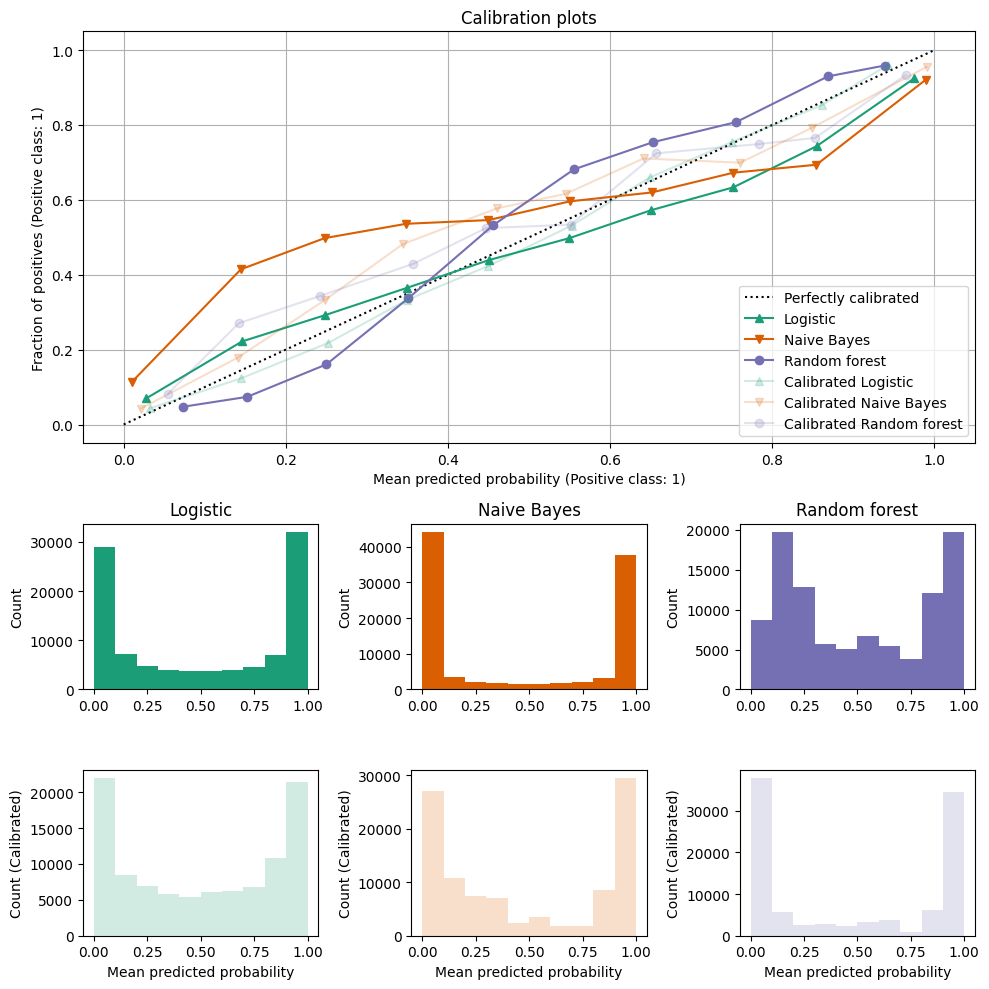

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 3)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :3])
calibration_displays = {}
markers = ["^", "v", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

for i, (clf, name) in enumerate(clf_list):
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
    calibrated_clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        calibrated_clf,
        X_test,
        y_test,
        n_bins=10,
        name="Calibrated "+name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        alpha = 0.2
    )
    calibration_displays["Calibrated "+name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (2, 2)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, ylabel="Count")
grid_positions = [(3, 0), (3, 1), (3, 2)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays["Calibrated "+name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
        alpha = 0.2
    )    
    ax.set(xlabel="Mean predicted probability", ylabel="Count (Calibrated)")

plt.tight_layout()
plt.show()

## Задачи регрессии

Учет вероятностной природы машинного обучения в задачах регрессии сводится к анализу распределений значений предсказаний. Другими словами, вместо классической задачи сопоставлнеия вектора значений $\textbf{y}$ входнму вектору параметорв $\textbf{x}$ мы должны искать распределение $p(\textbf{y})$ соответсвующее входному вектору $\textbf{x}$.

### Параметрические модели

Использование параметрических моделей машинного обучения (таких как линейная регрессия) позволяет довольно просто найти распределение выходного вектора. В самом деле, параметрические модели позволяют однозначно определить предсказаный вектор по входному вектору $\textbf{x}$ и вектору параметров $\textbf{θ}$:

 $$\textbf{y} = f(\textbf{x}, \textbf{θ})$$
 
В классическом (не-вероятностом) машинном обучении мы находим значения параметров $ \textbf{θ}$ минимизирующие функцию потерь (например, MLE) и используем это значение для предсказаний. Однако если мы рассмотрим  $ \textbf{θ}$  как случайную величину (распределенную по апостериорному распределению $p(\textbf{θ}|\mathcal{D})$), то  вектора предсказаний так же будет случайной величиной. В соотвествтии с рассуждениями приведенными в лекции 3, мы можем получить распределение  $\textbf{y}$ в явном виде если преобразование $f(\textbf{x}, \textbf{θ})$ непрерывно по $ \textbf{θ}$ или мы можем восопльзоваться численными методами, например аппроксимацией Монте-Карло.

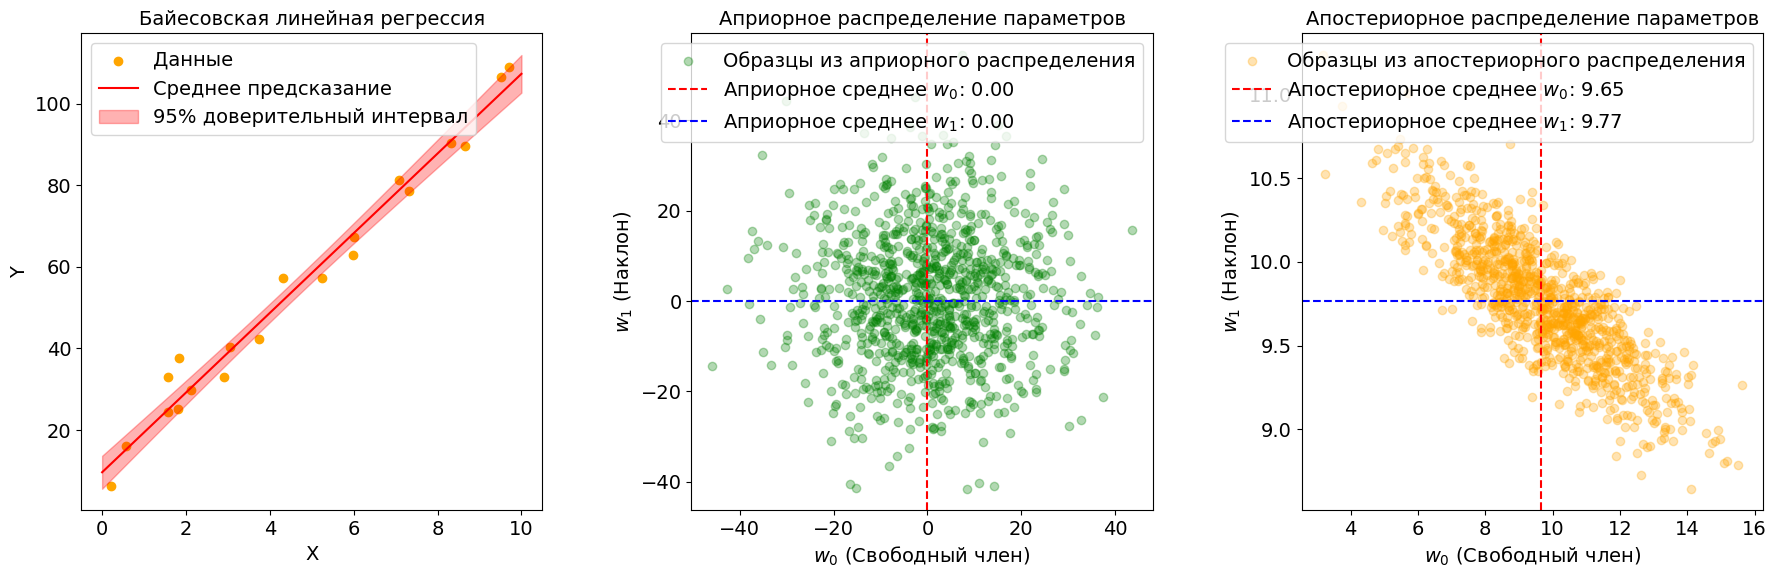

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация синтетических данных
np.random.seed(42)

size = 20
true_w0, true_w1 = 10, 10  # Истинные параметры
w_prior = np.array([0, 0])  # Среднее значение для априорного распределения
sigma_prior = np.eye(2) * 200  # Ковариационная матрица априорного распределения
sigma_noise = 5.0  # Шум (будем считать его известным)

X = np.random.uniform(0, 10, size=size) 
y = true_w0 + true_w1 * X + np.random.normal(0, sigma_noise, size=X.shape)

# Добавление смещения (bias) к X
X_design = np.c_[np.ones(X.shape), X]

# Вычисление апостериорного распределения с учетом априорного
sigma_posterior_inv = np.linalg.inv(sigma_prior) + (X_design.T @ X_design) / sigma_noise**2
sigma_posterior = np.linalg.inv(sigma_posterior_inv)
w_posterior = sigma_posterior @ (
    np.linalg.inv(sigma_prior) @ w_prior + X_design.T @ y / sigma_noise**2
)

# Образцы из априорного распределения
prior_samples = np.random.multivariate_normal(w_prior, sigma_prior, size=1000)

# Образцы из апостериорного распределения
posterior_samples = np.random.multivariate_normal(w_posterior, sigma_posterior, size=1000)

# Прогнозное распределение с использованием апостериорного распределения
X_test = np.linspace(0, 10, 100)
X_test_design = np.c_[np.ones(X_test.shape), X_test]
y_pred_mean = X_test_design @ w_posterior
y_pred_std = np.sqrt(np.sum(X_test_design @ sigma_posterior * X_test_design, axis=1))

# Построение графиков
plt.figure(figsize=(18, 6))

# Данные и предсказания
plt.subplot(1, 3, 1)
plt.scatter(X, y, label="Данные", color="orange")
plt.plot(X_test, y_pred_mean, label="Среднее предсказание", color='red')
plt.fill_between(
    X_test,
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    color='red',
    alpha=0.3,
    label="95% доверительный интервал"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Байесовская линейная регрессия")

# Априорные образцы параметров
plt.subplot(1, 3, 2)
plt.scatter(prior_samples[:, 0], prior_samples[:, 1], alpha=0.3, color="green", label="Образцы из априорного распределения")
plt.axvline(w_prior[0], color='red', linestyle='--', label=f"Априорное среднее $w_0$: {w_prior[0]:.2f}")
plt.axhline(w_prior[1], color='blue', linestyle='--', label=f"Априорное среднее $w_1$: {w_prior[1]:.2f}")
plt.xlabel("$w_0$ (Свободный член)")
plt.ylabel("$w_1$ (Наклон)")
plt.legend()
plt.title("Априорное распределение параметров")

# Апостериорные образцы параметров
plt.subplot(1, 3, 3)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.3, color="orange", label="Образцы из апостериорного распределения")
plt.axvline(w_posterior[0], color='red', linestyle='--', label=f"Апостериорное среднее $w_0$: {w_posterior[0]:.2f}")
plt.axhline(w_posterior[1], color='blue', linestyle='--', label=f"Апостериорное среднее $w_1$: {w_posterior[1]:.2f}")
plt.xlabel("$w_0$ (Свободный член)")
plt.ylabel("$w_1$ (Наклон)")
plt.legend()
plt.title("Апостериорное распределение параметров")

plt.tight_layout()
plt.show()


Если величина флуктуаций значений неизвестна, то вероятностную модель можно расшироть включив в нее параметр описыващий шум. Например, пусть мы верим что для заданого вектора $\textbf{x}$ значения $y$ будут распределены нормально с $\mathcal{N}(\mu,\sigma^2)$, где $\mu$ описывает линейную регрессию (как в примере выше), а $ \sigma^2$ - шум данных. Обученая модель будет описывать распределение вероятностей для $y$ так:

$$p(y|x,\mathcal{D},\sigma^2) = \int \mathcal(y|\textbf{w}^T\textbf{x} + b,\sigma^2 )p(\textbf{w},b|\mathcal{D})d\textbf{w}db$$


Видно, что в данном случае дисперсия предсказаной величины будет зависить от распределения параметров  $\textbf{w},b$ и от шума данных $\sigma^2$.


## Регрессия с непараметрическими моделями


Байесовская линейная регрессия позволяет получить полное распределене предсказаний модели. Однако, это зачастую сложно осуществимо аналитически и/или дорого вычислительно. Кроме того, линейная регрессия зачастую генерализует данные хуже чем другие (непараметрические) модели (такие как ансамбли решающих деревьев, нейронные сети, и т.п.). Наконец, полное предсказание распределения искомой величины зачастую излишне - для практических целей бывает достаточно определить интервал значений.

### Квантильная регрессия

Давайте рассмотрим задачу построения модели для величины $\hat{y}_\tau$, такой что:


$$P(Y \leq \hat{y}_\tau \mid X) = \tau$$


где:
- $Y$ — целевая переменная,
- $X$ — набор признаков,
- $\tau \in (0, 1)$ — заданный квантиль (например, 0.1, 0.5, 0.9).

Это формулировка задачи __квантильной регрессии__. Нахождене искомой величины сводится к минимизации функции потерь "Pinball":

$$L_\tau(y, \hat{y}) =
\begin{cases}
\tau (y - \hat{y}), & \text{если } y > \hat{y}, \\
(1 - \tau) (\hat{y} - y), & \text{если } y \leq \hat{y}.
\end{cases}
$$

В самом деле, матожидание функции потерь можно записать как 
$$\mathbb{E} \big[ L_\tau(y, \hat{y}) \big] = \int_{-\infty}^{\infty} L_\tau(y, \hat{y}) P(y) \, dy,$$

где $P(y)$ -  это (неизвестная нам) плотность распределения целевой переменной. Разделим интеграл на две части

$$\mathbb{E} \big[ L_\tau(y, \hat{y}) \big] =
\int_{-\infty}^{\hat{y}} (1 - \tau) (\hat{y} - y) P(y) \, dy +
\int_{\hat{y}}^{\infty} \tau (y - \hat{y}) P(y) \, dy$$

и продифференциируем:

$$\frac{\partial}{\partial \hat{y}} \mathbb{E} \big[ L_\tau(y, \hat{y}) \big] =
\frac{\partial}{\partial \hat{y}} \left[ \int_{-\infty}^{\hat{y}} (1 - \tau) (\hat{y} - y) P(y) \, dy +
\int_{\hat{y}}^{\infty} \tau (y - \hat{y}) P(y) \, dy \right].$$


Для первой части $( y \leq \hat{y}) $:
$$
\frac{\partial}{\partial \hat{y}} \int_{-\infty}^{\hat{y}} (1 - \tau) (\hat{y} - y) P(y) \, dy =
(1 - \tau) \int_{-\infty}^{\hat{y}} P(y) \, dy - (1 - \tau) \hat{y} P(\hat{y}).
$$

Для второй части $( y > \hat{y} )$:
$$
\frac{\partial}{\partial \hat{y}} \int_{\hat{y}}^{\infty} \tau (y - \hat{y}) P(y) \, dy =
-\tau \int_{\hat{y}}^{\infty} P(y) \, dy + \tau \hat{y} P(\hat{y}).
$$


Объединяя эти части:
$$
\frac{\partial}{\partial \hat{y}} \mathbb{E} \big[ L_\tau(y, \hat{y}) \big] =
(1 - \tau) F(\hat{y}) - \tau (1 - F(\hat{y})),
$$

где $ F(\hat{y}) = \int_{-\infty}^{\hat{y}} P(y) \, dy $ — это функция распределения (CDF).

Приравняем производную к нулю:
$$
(1 - \tau) F(\hat{y}) = \tau (1 - F(\hat{y})).
$$

Упростим:
$$
F(\hat{y}) = \tau.
$$

Таким образом, минимизация функции потерь "Pinball" для любой (даже непараметрической) модели позволяет оценить доверительный интервал предсказаний модели. 

Сравним доверительные интервалы байесовской линейной регресси и интервалы полученные в квантильной регрессии:

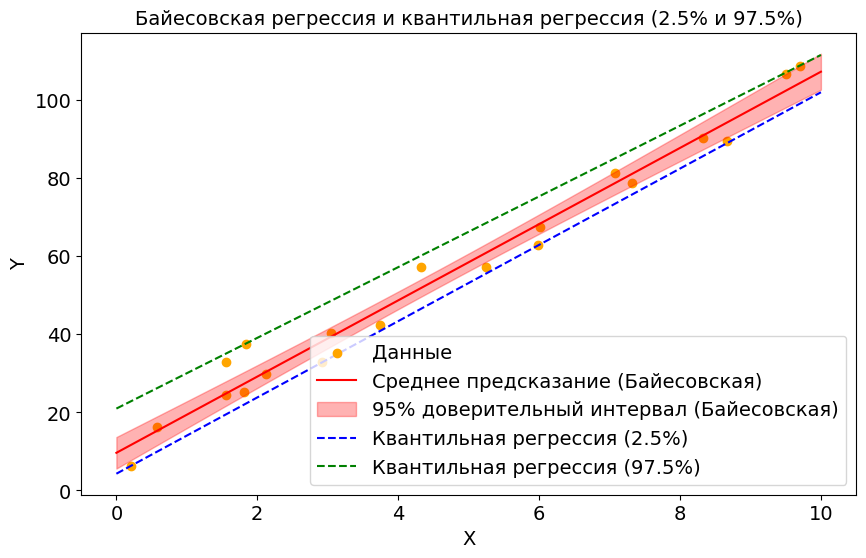

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor

# Генерация синтетических данных
np.random.seed(42)

size = 20
true_w0, true_w1 = 10, 10  # Истинные параметры
w_prior = np.array([0, 0])  # Среднее значение для априорного распределения
sigma_prior = np.eye(2) * 200  # Ковариационная матрица априорного распределения
sigma_noise = 5.0  # Шум (будем считать его известным)

X = np.random.uniform(0, 10, size=size) 
y = true_w0 + true_w1 * X + np.random.normal(0, sigma_noise, size=X.shape)

# Добавление смещения (bias) к X
X_design = np.c_[np.ones(X.shape), X]

# Вычисление апостериорного распределения с учетом априорного
sigma_posterior_inv = np.linalg.inv(sigma_prior) + (X_design.T @ X_design) / sigma_noise**2
sigma_posterior = np.linalg.inv(sigma_posterior_inv)
w_posterior = sigma_posterior @ (
    np.linalg.inv(sigma_prior) @ w_prior + X_design.T @ y / sigma_noise**2
)

# Прогнозное распределение с использованием апостериорного распределения
X_test = np.linspace(0, 10, 100)
X_test_design = np.c_[np.ones(X_test.shape), X_test]
y_pred_mean = X_test_design @ w_posterior
y_pred_std = np.sqrt(np.sum(X_test_design @ sigma_posterior * X_test_design, axis=1))

# Квантильная регрессия
quantile_2_5 = QuantileRegressor(quantile=0.025, alpha=0, solver="highs").fit(X.reshape(-1, 1), y)
quantile_97_5 = QuantileRegressor(quantile=0.975, alpha=0, solver="highs").fit(X.reshape(-1, 1), y)

y_quantile_2_5 = quantile_2_5.predict(X_test.reshape(-1, 1))
y_quantile_97_5 = quantile_97_5.predict(X_test.reshape(-1, 1))

# Построение графиков
plt.figure(figsize=(10, 6))

# Данные и предсказания
plt.scatter(X, y, label="Данные", color="orange")
plt.plot(X_test, y_pred_mean, label="Среднее предсказание (Байесовская)", color='red')
plt.fill_between(
    X_test,
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    color='red',
    alpha=0.3,
    label="95% доверительный интервал (Байесовская)"
)
plt.plot(X_test, y_quantile_2_5, color="blue", linestyle="--", label="Квантильная регрессия (2.5%)")
plt.plot(X_test, y_quantile_97_5, color="green", linestyle="--", label="Квантильная регрессия (97.5%)")

# Подписи и оформление
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Байесовская регрессия и квантильная регрессия (2.5% и 97.5%)")
plt.show()


Выделим следующие различия:
- Квантильная регрессия осуществляется двумя точечными оценками параметров модели, в то время как границы интервала полученного в байесовской регрессии опредлеяются всеми возможными прямыми включенными в интервал наибольшей плотности в пространстве параметров модели.
- В примере выше границы квантильной регрессии не параллельны. Так, при экстраполяции в область больших X, доверительный интервал квантильной регресси будет уменьшаться (тогда как доверительные интервалы байесовской регрессии будут расти, как и следует ожидать). Таким образом, квантильная регрессия применима только в режиме интерполяции.
- Квантильная регрессия не зависит от априорных значений
- Квантили определяются данными, а не моделями. При малом количестве данных квантили будут нестабильны.


### Бутстрап

В случае, когда необходимо все же построить распределение предсказаний для непараметрической модели можно воспользоваться бутстрапом - как было продемонстрировано в Лекции 6. Идея этого подхода заключается в тренировке большого числа моделей на выборках из тренировочной выборки и анализа распределений $y$ полученых на разных моделях. Этот способ подходит для любой модели но он плохо масштабируется с ростом данных числа данных и сложностьи модели, может давать смещеную оценку, и не позволяет учитывать априорные знание о шуме данных.

Сравним распределения полученные бутстрапом с "честными" апостериорным байесовским распределением.

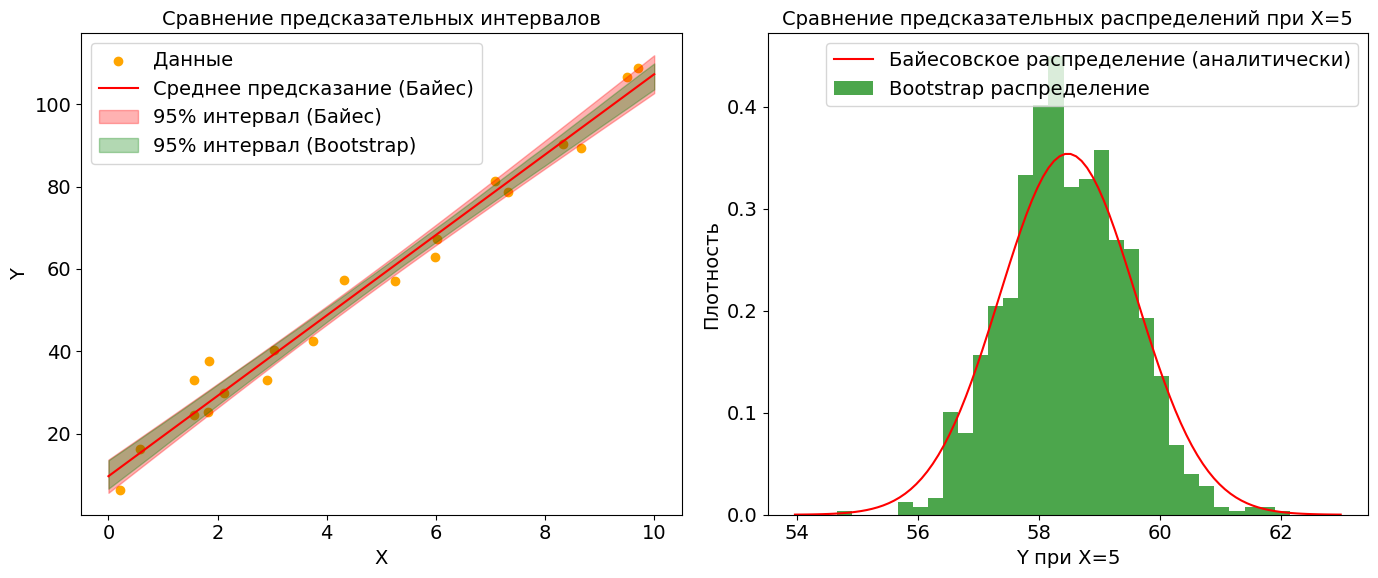

In [122]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Генерация синтетических данных
np.random.seed(42)

size = 20
true_w0, true_w1 = 10, 10  # Истинные параметры
w_prior = np.array([0, 0])  # Среднее значение для априорного распределения
sigma_prior = np.eye(2) * 200  # Ковариационная матрица априорного распределения
sigma_noise = 5.0  # Шум (будем считать его известным)

X = np.random.uniform(0, 10, size=size) 
y = true_w0 + true_w1 * X + np.random.normal(0, sigma_noise, size=X.shape)

# Добавление смещения (bias) к X
X_design = np.c_[np.ones(X.shape), X]

# Вычисление апостериорного распределения с учетом априорного
sigma_posterior_inv = np.linalg.inv(sigma_prior) + (X_design.T @ X_design) / sigma_noise**2
sigma_posterior = np.linalg.inv(sigma_posterior_inv)
w_posterior = sigma_posterior @ (
    np.linalg.inv(sigma_prior) @ w_prior + X_design.T @ y / sigma_noise**2
)

# Прогнозное распределение с использованием апостериорного распределения
X_test = np.linspace(0, 10, 100)
X_test_design = np.c_[np.ones(X_test.shape), X_test]
y_pred_mean = X_test_design @ w_posterior
y_pred_std = np.sqrt(np.sum(X_test_design @ sigma_posterior * X_test_design, axis=1))

# Добавление bootstrap
n_bootstraps = 1000
bootstrap_preds = []

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X, y)
    X_resampled_design = np.c_[np.ones(X_resampled.shape), X_resampled]
    w_bootstrap = np.linalg.lstsq(X_resampled_design, y_resampled, rcond=None)[0]
    y_bootstrap_pred = X_test_design @ w_bootstrap
    bootstrap_preds.append(y_bootstrap_pred)

bootstrap_preds = np.array(bootstrap_preds)
bootstrap_mean = np.mean(bootstrap_preds, axis=0)
bootstrap_lower = np.percentile(bootstrap_preds, 5, axis=0)
bootstrap_upper = np.percentile(bootstrap_preds, 95, axis=0)

# Predictive distribution comparison at X = 5
X_single = np.array([1, 5]).reshape(1, -1)  # Bias term + feature value
y_bayes_at_5_mean = X_single @ w_posterior
y_bayes_at_5_std = np.sqrt(X_single @ sigma_posterior @ X_single.T)

# Define a range for plotting the Bayesian predictive distribution
y_range = np.linspace(y_bayes_at_5_mean - 4 * y_bayes_at_5_std, 
                      y_bayes_at_5_mean + 4 * y_bayes_at_5_std, 100).reshape(-1, 1)

# Compute the Bayesian predictive distribution analytically (Normal PDF)
y_bayes_pdf = norm.pdf(y_range, loc=y_bayes_at_5_mean, scale=y_bayes_at_5_std)

# Сравнение распределений предсказаний при X=5 (график справа)
bootstrap_at_5_preds = []
for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X, y)
    X_resampled_design = np.c_[np.ones(X_resampled.shape), X_resampled]
    w_bootstrap = np.linalg.lstsq(X_resampled_design, y_resampled, rcond=None)[0]
    bootstrap_at_5_preds.append(X_single @ w_bootstrap)

bootstrap_at_5_preds = np.array(bootstrap_at_5_preds)

# Построение графиков
plt.figure(figsize=(14, 6))

# Прогнозные интервалы (график слева)
plt.subplot(1, 2, 1)
plt.scatter(X, y, label="Данные", color="orange")
plt.plot(X_test, y_pred_mean, label="Среднее предсказание (Байес)", color='red')
plt.fill_between(
    X_test,
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    color='red',
    alpha=0.3,
    label="95% интервал (Байес)"
)
plt.fill_between(
    X_test,
    bootstrap_lower,
    bootstrap_upper,
    color='green',
    alpha=0.3,
    label="95% интервал (Bootstrap)"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Сравнение предсказательных интервалов")

# Сравнение распределений предсказаний при X=5 (график справа)
plt.subplot(1, 2, 2)
# Plot Bayesian predictive distribution as a smooth curve
plt.plot(y_range.flatten(), y_bayes_pdf.flatten(), color="red", label="Байесовское распределение (аналитически)")
plt.hist(
    bootstrap_at_5_preds,
    bins=30,
    alpha=0.7,
    label="Bootstrap распределение",
    color="green",
    density=True
)
# plt.axvline(y_bayes_at_5_mean, color="red", linestyle="--", label="Байес Среднее")
# plt.axvline(np.mean(bootstrap_at_5_preds), color="green", linestyle="--", label="Bootstrap Среднее")
plt.xlabel("Y при X=5")
plt.ylabel("Плотность")
plt.legend()
plt.title("Сравнение предсказательных распределений при X=5")

plt.tight_layout()
plt.show()


Как видно, в этом случае бутстрап позволил получить очень хорошее приближение к распределению из баейсовской регресии.

### Вероятностное моделирование целевой переменной

Наконец, если известен тип распределения целевой переменной (например, известно, что она будет распределена нормально), то можно использовать это знание при вероятностном моделировании. В этом случае задача сводится к предсказанию параметров этих распределений (например, среднего и дисперсии) средствами непараметрической модели. Так, если мы выбираем распределение $p(y_i \mid \theta(x_i))$ для целевой переменной, то для определения параметров $ \theta(x_i) $ этого распределения можно минимизировать функцию правдоподобия:

  $$
  \mathcal{L} = -\sum_{i=1}^n \log p(y_i \mid \theta(x_i)),
  $$
 где параметры $ \theta(x_i) $ предсказаны одной (или несколькими) моделями машинного обучения  (например, решающими деревьями).
Этот подход реализован в библиотеках [XGBoostLSS](https://github.com/StatMixedML/XGBoostLSS) и [NGBoost](https://github.com/stanfordmlgroup/ngboost).

Библиотека [BART](https://github.com/JakeColtman/bartpy) предсказывает апостериорное распределение через ансамбль деревьев. Оптимизирует остаточную дисперсию $ \sigma^2 $ и структуру деревьев:
  $$
  p(y \mid X) = \frac{1}{N} \sum_{i=1}^N \mathcal{N}(y \mid f^{(i)}(X), \sigma^{2(i)}),
  $$
  где N это размер ансамбля, а $ f^{(i)}(X) $ и $ \sigma^{2(i)} $ — предсказания сэмплов MCMC.


[iter 0] loss=3.1984 val_loss=0.0000 scale=2.0000 norm=10.3102
[iter 100] loss=2.1644 val_loss=0.0000 scale=2.0000 norm=2.7076
[iter 200] loss=1.6117 val_loss=0.0000 scale=2.0000 norm=2.1585
[iter 300] loss=1.1892 val_loss=0.0000 scale=4.0000 norm=3.7620
[iter 400] loss=0.9359 val_loss=0.0000 scale=2.0000 norm=1.6658


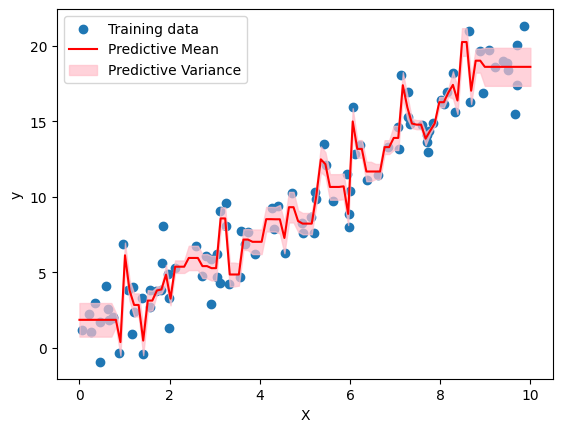

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from sklearn.ensemble import GradientBoostingRegressor

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y = 2 * X.squeeze() + np.random.randn(100) * 2

# Create an ngboost model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
ngb = NGBRegressor(Base=gbr, Dist=Normal, natural_gradient=True)

# Fit the model to the entire dataset
ngb.fit(X, y)

# Make predictions on the entire X range
X_range = np.linspace(0, 10, 100).reshape(-1, 1)
y_mean_range = ngb.predict(X_range)
y_std_range = np.sqrt(ngb.pred_dist(X_range).params['scale'])

# Plot the training dataset, predictive mean, and variance
plt.scatter(X, y, label='Training data')
plt.plot(X_range, y_mean_range, label='Predictive Mean', color='red')
plt.fill_between(X_range.squeeze(), y_mean_range - y_std_range, y_mean_range + y_std_range, color='pink', alpha=0.7, label='Predictive Variance')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


### Гауссовские процессы

Синтетические модели библиотеки ```ngboost``` позволяют получить распределение искомой величины и тем самым являются _вероятностными моделями_. Другим важным примером вероятностых моделей являются гауссовские процессы. Гауссовский процесс - это алгоритм принадлежащий к семейству ядерных методов. Это непараметрические методы машинного обучения в которых тип функции описывающей связь входного вектора и предсказаний определяется из данных.

Гауссовский процесс (ГП) - это стохастический процесс, который полностью характеризуется своим средним значением и ковариационной функцией. ГП часто используется в статистике и машинном обучении для моделирования случайных функций и данных.

Основные идеи гауссовских процессов:

1. **Нормальное распределение:** Каждый конечный набор значений из гауссовского процесса распределен нормально. Таким образом, даже если мы рассматриваем только конечное количество точек процесса, они всегда будут иметь нормальное распределение.

2. **Ковариационная функция:** Ковариационная функция определяет степень зависимости между значениями процесса в разных точках. Она указывает, насколько сильно значение в одной точке процесса коррелирует с значением в другой точке. Гауссовский процесс полностью определяется своей ковариационной функцией.

3. **Гибкость:** Гауссовские процессы обладают высокой гибкостью и могут использоваться для моделирования различных видов функций, включая гладкие кривые, периодические сигналы, шумные данные и другие.

4. **Байесовский подход:** Гауссовские процессы также широко используются в байесовском машинном обучении. При использовании ГП в качестве априорного распределения набора функций, мы можем обновлять наши представления о функции, основываясь на новых данных, с помощью теоремы Байеса.

Гауссовские процессы находят применение в различных областях, таких как регрессия, оптимизация, а также в моделировании неопределенности в различных задачах машинного обучения.

/Users/komari/lectures/From-Stats-to-ML/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


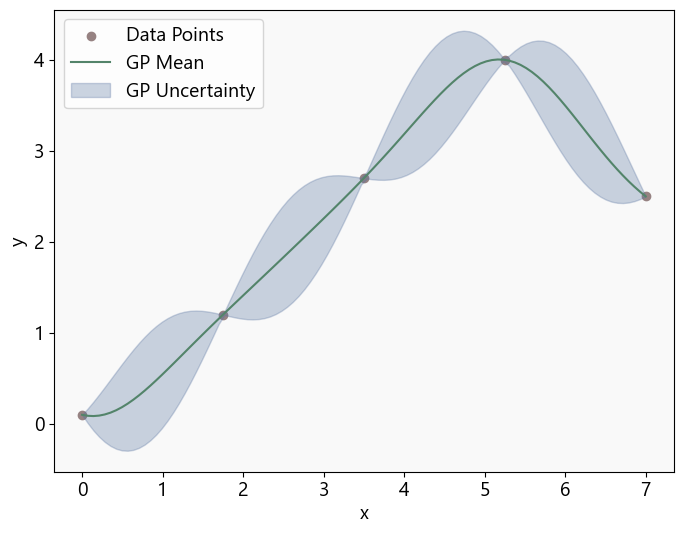

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate random data points
upper_l = 7
num_points = 5
x_data = np.sort(np.linspace(0, upper_l, num_points))
y_data = np.array([0.1,  1.2,  2.7,  4.0, 2.5])  # Replace with your data

# Reshape the data for GaussianProcessRegressor
x_data = x_data.reshape(-1, 1)

# Define the kernel for Gaussian Process with increased length scale
kernel =  1.0 * RBF(length_scale=0.5, length_scale_bounds=(1e-1, 1.0))

# Fit Gaussian Process to the data
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y = True)
gp.fit(x_data, y_data)

# Generate points for prediction
x_pred = np.linspace(0, upper_l, 100)
x_pred = x_pred.reshape(-1, 1)

# Predict mean and standard deviation using GP
y_pred_mean, y_pred_std = gp.predict(x_pred, return_std=True)

plt.rcParams['font.sans-serif'] = 'Segoe UI'

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, color='#968282', label='Data Points')
plt.plot(x_pred, y_pred_mean, color='#53846A', label='GP Mean')
plt.fill_between(x_pred.ravel(), y_pred_mean - y_pred_std, y_pred_mean + y_pred_std, color='#56729F', alpha=0.3, label='GP Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
# plt.title('How we believe taste depends on salt?')
plt.legend()
plt.gca().set_facecolor('#F9F9F9')
plt.grid(False)


## Конформные предсказания

Метод конформных предсказаний позволяет оценить доверительный интревал предсказаний для любой модели машинного обучения при услови взаимозаменяемости данных - то есть вероятностный закон не должен меняться из-за перемены данных (это немного более слабое требование чем тренбование независимости и одинакового распределения данных (i.i.d.)). 

Самый простой способ построения доверительных интревалов этим методом - это анализ абсолютной  ошибки (_меры конформности_ $\delta y_i$) на тренировочном (или валидационном) наборе данных:
$$\delta y_i = |y_i - \hat{y}_i|$$



/Users/komari/lectures/From-Stats-to-ML/venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


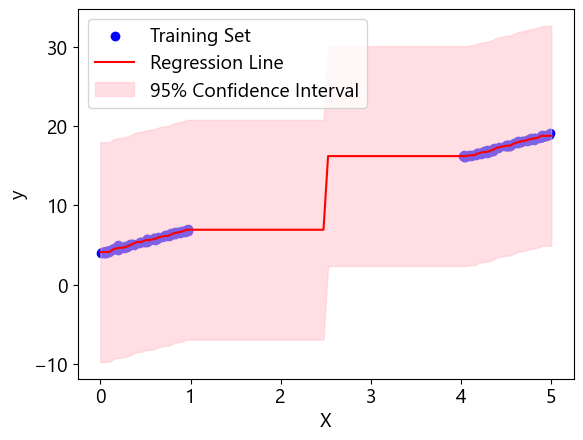

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Generate random data
np.random.seed(42)
X1 = np.random.rand(100, 1)
X2 = 4+np.random.rand(100, 1)
X = np.concatenate((X1,X2))
y = 4 + 3 * X + 0.1*np.random.randn(200, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
# model = LinearRegression()
model =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
model.fit(X_train, y_train)

# Make predictions on the test set
delta_y = np.abs(y_train - model.predict(X_train))

delta_y_95p = np.quantile(delta_y, 0.95)


# Generate new data points for plotting the regression line
X_new = np.linspace(0, 5, 100).reshape(-1, 1)

# Plot the training set, regression line, and confidence interval
plt.scatter(X_train, y_train, color='blue', label='Training Set')
plt.plot(X_new, model.predict(X_new), color='red', label='Regression Line')
plt.fill_between(X_new.flatten(), (model.predict(X_new) - delta_y_95p).flatten(), (model.predict(X_new) + delta_y_95p).flatten(), color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Это вариант оценки создает доверительный интервал одинаковой ширины для любого предсказания. Кроме того, при использовании тренировочного набора данных он склонен к перетренировке, а использование валидационного набора данных требует жертвы этих самых валидационных данных для оценки ошибки.

Более продвинутые методы оценки позволяют получать распределения меры конформности из кросс-валидационных моделей. Например, Jacknife+-after-bootrstrap метод использует бутстрап для построения дополнительных моделей.

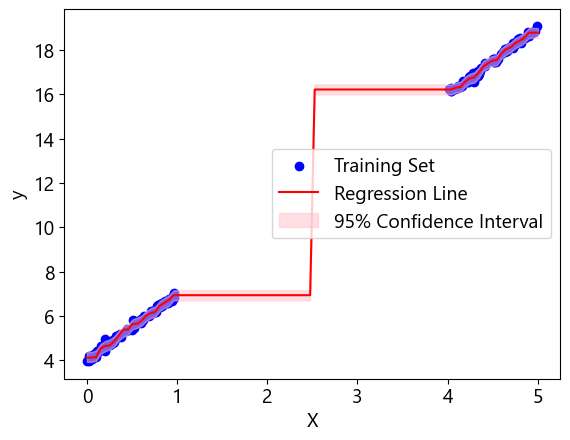

In [12]:

# Get bootrstrapped models
n_samples = 50
data = np.array(list(zip(X_train, y_train)))
data = data.reshape(len(data),2)
rng = np.random.default_rng()
bs_data = []
bs_models = []
bs_test_predictions = [[] for _ in data]
bs_train_predictions = []
for i in range(n_samples):
    # Randomly select data with replacement
    bs_indices = np.random.choice(len(data), len(data), replace=True)
    _bs_data = data[bs_indices].T

    # Find the entries that didn't make it to the random vectors
    all_indices = np.arange(len(data))
    unselected_indices = np.setdiff1d(all_indices, bs_indices)
    _data_not_in_bs = data[unselected_indices].T
    
    # Training the model
    _model =  GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2,min_samples_leaf = 10)
    _model.fit(_bs_data[0].reshape(-1,1),_bs_data[1])
    
    # Getting predictions datapoints not in the training set
    # We will use it to compute conformity scores
    bs_train_predictions += list(zip(_data_not_in_bs[0],_model.predict(_data_not_in_bs[0].reshape(-1,1))))
    
#     # Getting predictions for the training datasets
    new_predictions = _model.predict(X_new)
    for i in unselected_indices:
        bs_test_predictions[i].append(_model.predict(X_new))
    
    # Saving bootstrap results
    bs_data.append(_bs_data)
    bs_models.append(_model)
    
# Aggregating conformity scores and predictions
conformity_scores = []
mins = []
maxs = []
for i, d in enumerate(data):
    x = d[0]
    y = []
    for p in bs_train_predictions:
        if p[0] == x:
            y.append(p[1])
    conformity_score = np.abs(d[1]-np.mean(y))
    conformity_scores.append(conformity_score)
    
    predictions = np.median(np.array(bs_test_predictions[i]), axis = 0)
    
    mins.append(predictions - conformity_score)
    maxs.append(predictions + conformity_score)
    
    
mins = np.quantile(mins, 0.05, axis = 0)
maxs = np.quantile(maxs, 0.95, axis = 0)
    
# Plot the training set, regression line, and confidence interval
plt.scatter(X_train, y_train, color='blue', label='Training Set')
plt.plot(X_new, model.predict(X_new), color='red', label='Regression Line')
plt.fill_between(X_new.flatten(), mins, maxs, color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
        